# Analysing Training Data Amount Effect

In [ ]:
%%capture
# Run to set environment variables if want to
# %env HF_TOKEN=

In [ ]:
%%capture
import os
# If getting 'Could not find project LASR_probe_gen' get key from https://wandb.ai/authorize and paste below
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_API_KEY"] = ""
import wandb
wandb_token = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_token)

### Adding on_policy training data

Loading on_policy data...

Training with ONLY on_policy data (baseline)

On_policy only → ROC-AUC: 0.979

Training with ALL incentivised + varying on_policy

On_policy added: 100 → ROC-AUC: 0.697
On_policy added: 200 → ROC-AUC: 0.701
On_policy added: 300 → ROC-AUC: 0.699
On_policy added: 400 → ROC-AUC: 0.704
On_policy added: 500 → ROC-AUC: 0.700
On_policy added: 600 → ROC-AUC: 0.699
On_policy added: 700 → ROC-AUC: 0.687
On_policy added: 800 → ROC-AUC: 0.699
On_policy added: 900 → ROC-AUC: 0.695
On_policy added: 1000 → ROC-AUC: 0.702
On_policy added: 1100 → ROC-AUC: 0.694
On_policy added: 1200 → ROC-AUC: 0.700
On_policy added: 1300 → ROC-AUC: 0.697
On_policy added: 1400 → ROC-AUC: 0.686
On_policy added: 1500 → ROC-AUC: 0.689
On_policy added: 1600 → ROC-AUC: 0.694
On_policy added: 1700 → ROC-AUC: 0.689
On_policy added: 1800 → ROC-AUC: 0.685
On_policy added: 1900 → ROC-AUC: 0.687
On_policy added: 2000 → ROC-AUC: 0.695
On_policy added: 2100 → ROC-AUC: 0.690
On_policy added: 2200 → ROC-AUC:

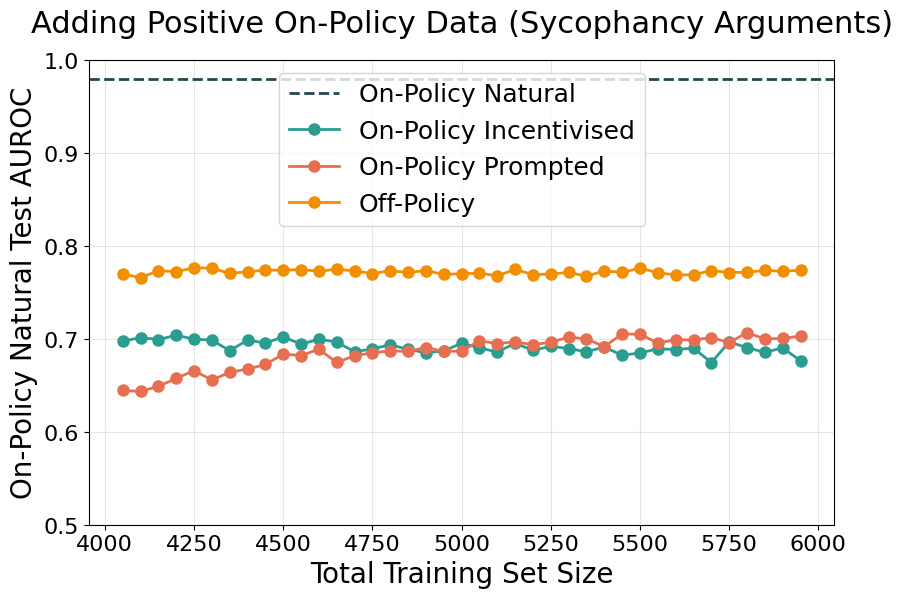

In [ ]:
# Decide if want to increase all data or just positives or just negatives
increase_data = ["all", "positives", "negatives"][0]

# Balanced data, increasing positives and negatives
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict
    
import torch
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

probe_type = ["mean", "attention_torch"][0]
behaviour = "sycophancy"
datasource = "arguments"
# datasource = "multichoice"
activations_model = "llama_3b"
response_model = "llama_3b"
# off_policy_model = "ministral_8b"
off_policy_model = "qwen_7b"
mode = "train"

# Load the best hyperparameters or set your own
dataset_name = None
cfg = ConfigDict.from_json(activations_model, probe_type, behaviour)

# Define subset sizes to test (must be even)
subset_sizes = list(range(100, 4000, 100))

# Fixed test generation method
test_generation_method = "on_policy"

# Load test dataset once (since it's fixed)
used_model_test = response_model if test_generation_method != "off_policy" else off_policy_model
activations_tensor_test, attention_mask_test, labels_tensor_test = probes.load_hf_activations_at_layer(
    behaviour, datasource, activations_model, used_model_test, test_generation_method, "test", cfg.layer, and_labels=True)
if "mean" in probe_type:
    activations_tensor_test = probes.MeanAggregation()(activations_tensor_test, attention_mask_test)
_, _, test_dataset = probes.create_activation_datasets(
    activations_tensor_test, labels_tensor_test, splits=[0, 0, 1000])

# Load on_policy data separately
print("Loading on_policy data...")
used_model_on = response_model
activations_on, attention_mask_on, labels_on = probes.load_hf_activations_at_layer(
    behaviour, datasource, activations_model, used_model_on, "on_policy", mode, cfg.layer, and_labels=True)
if "mean" in probe_type:
    activations_on = probes.MeanAggregation()(activations_on, attention_mask_on)

pos_indices_on = (labels_on == 1).nonzero(as_tuple=True)[0]
neg_indices_on = (labels_on == 0).nonzero(as_tuple=True)[0]

# Store results for each generation method
all_results = {}

# First, train with ONLY on_policy data (baseline)
print(f"\n{'='*60}")
print(f"Training with ONLY on_policy data (baseline)")
print(f"{'='*60}\n")

# Use all on_policy data
all_on_idx = torch.cat([pos_indices_on, neg_indices_on])
all_on_idx = all_on_idx[torch.randperm(len(all_on_idx))]

activ_on_all = activations_on[all_on_idx]
label_on_all = labels_on[all_on_idx]

n_train = int(0.8 * len(label_on_all))
n_val = len(label_on_all) - n_train
train_dataset, val_dataset, _ = probes.create_activation_datasets(
    activ_on_all, label_on_all, splits=[n_train, n_val, 0]
)

if probe_type == "mean":
    probe = probes.SklearnLogisticProbe(cfg)
elif probe_type == "mean_torch":
    probe = probes.TorchLinearProbe(cfg)
elif probe_type == "attention_torch":
    probe = probes.TorchAttentionProbe(cfg)

probe.fit(train_dataset, val_dataset)
eval_dict, _, _ = probe.eval(test_dataset)
on_policy_score = eval_dict["roc_auc"]
print(f"On_policy only → ROC-AUC: {on_policy_score:.3f}")

# Store as horizontal line (same value for all subset sizes)
all_results["on_policy"] = {n: on_policy_score for n in subset_sizes}

# Now iterate over other generation methods, using ALL their data + varying amounts of on_policy
for generation_method in ["incentivised", "prompted", "off_policy"]:
    print(f"\n{'='*60}")
    print(f"Training with ALL {generation_method} + varying on_policy")
    print(f"{'='*60}\n")
    
    # Load ALL training activations for this generation method
    used_model = response_model if generation_method != "off_policy" else off_policy_model
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_at_layer(
        behaviour, datasource, activations_model, used_model, generation_method, mode, cfg.layer, and_labels=True)
    if "mean" in probe_type:
        activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    
    results = {}
    
    for n in subset_sizes:
        half = n // 2
        
        # Sample on_policy data according to increase_data setting
        if increase_data == "all":
            pos_cut = half
            neg_cut = half
        elif increase_data == "positives":
            pos_cut = half
            neg_cut = 0  # No negatives from on_policy
        elif increase_data == "negatives":
            pos_cut = 0  # No positives from on_policy
            neg_cut = half
        
        # Sample from on_policy
        pos_sample_on = pos_indices_on[torch.randperm(len(pos_indices_on))[:pos_cut]] if pos_cut > 0 else torch.tensor([], dtype=torch.long)
        neg_sample_on = neg_indices_on[torch.randperm(len(neg_indices_on))[:neg_cut]] if neg_cut > 0 else torch.tensor([], dtype=torch.long)
        
        on_policy_idx = torch.cat([pos_sample_on, neg_sample_on])
        
        # Get ALL data from the current generation method
        all_other_idx = torch.arange(len(labels_tensor))
        
        # Combine: all of current method + sampled on_policy
        activ_combined = torch.cat([activations_tensor, activations_on[on_policy_idx]])
        label_combined = torch.cat([labels_tensor, labels_on[on_policy_idx]])
        
        # Shuffle
        shuffle_idx = torch.randperm(len(label_combined))
        activ_combined = activ_combined[shuffle_idx]
        label_combined = label_combined[shuffle_idx]
    
        # Create datasets (e.g., 80% train, 20% val)
        n_train = int(0.8 * len(label_combined))
        n_val = len(label_combined) - n_train
        train_dataset, val_dataset, _ = probes.create_activation_datasets(
            activ_combined, label_combined, splits=[n_train, n_val, 0]
        )
    
        # Initialise and train probe
        if probe_type == "mean":
            probe = probes.SklearnLogisticProbe(cfg)
        elif probe_type == "mean_torch":
            probe = probes.TorchLinearProbe(cfg)
        elif probe_type == "attention_torch":
            probe = probes.TorchAttentionProbe(cfg)
    
        probe.fit(train_dataset, val_dataset)
    
        # Evaluate on the fixed test set
        eval_dict, _, _ = probe.eval(test_dataset)
        results[n] = eval_dict["roc_auc"]
    
        print(f"On_policy added: {n} → ROC-AUC: {eval_dict['roc_auc']:.3f}")
    
    # Store results for this generation method
    all_results[generation_method] = results

# Define color mapping for each generation method
color_map = {
    "on_policy": "#264653",      # dark blue
    "incentivised": "#2A9D8F",   # teal green
    "prompted": "#E76F51",       # red/orange
    "off_policy": "#F18F01"      # yellow/orange
}

# Define display names
label_map = {
    "on_policy": "On-Policy Natural",
    "incentivised": "On-Policy Incentivised",
    "prompted": "On-Policy Prompted",
    "off_policy": "Off-Policy"
}

# Determine x-axis offset based on increase_data
x_offset = 4000

# Create title with proper formatting
increase_data_display = increase_data.capitalize().replace("Positives", "Positive").replace("Negatives", "Negative")
behaviour_display = behaviour.capitalize()
datasource_display = datasource.capitalize()
plot_title = f"Adding {increase_data_display} On-Policy Data ({behaviour_display} {datasource_display})"

# Set font sizes
plt.rcParams.update({'font.size': 16})

# Plot all results on the same graph
plt.figure(figsize=(9, 6))
for gen_method, results in all_results.items():
    if gen_method == "on_policy":
        # Plot as horizontal line
        plt.axhline(y=list(results.values())[0], 
                   linestyle='--', 
                   label=label_map[gen_method],
                   color=color_map[gen_method],
                   linewidth=2)
    else:
        if increase_data == "all":
            x_values = [x + x_offset for x in results.keys()]
        else:
            x_values = [(x/2) + x_offset for x in results.keys()]
        plt.plot(x_values, list(results.values()), 
                marker='o', 
                label=label_map[gen_method],
                color=color_map[gen_method],
                linewidth=2,
                markersize=8)

plt.xlabel("Total Training Set Size", fontsize=20)
plt.ylabel("On-Policy Natural Test AUROC", fontsize=20)
plt.title(plot_title, fontsize=22, pad=20)
plt.grid(True, alpha=0.3)
# plt.legend(fontsize=18, loc='lower right')
plt.legend(fontsize=18, loc='upper center')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.ylim(0.5, 1.0)
plt.subplots_adjust(top=0.92)

# Save the plot as PDF
plt.savefig(f"{datasource}_adding_onpolicy_{increase_data}.pdf", format='pdf', bbox_inches='tight')

plt.show()

### Increasing training data


Training with generation method: on_policy

Subset size 100 → ROC-AUC: 0.697
Subset size 200 → ROC-AUC: 0.791
Subset size 300 → ROC-AUC: 0.795
Subset size 400 → ROC-AUC: 0.831
Subset size 500 → ROC-AUC: 0.847
Subset size 600 → ROC-AUC: 0.845
Subset size 700 → ROC-AUC: 0.862
Subset size 800 → ROC-AUC: 0.880
Subset size 900 → ROC-AUC: 0.896

Training with generation method: incentivised

Subset size 100 → ROC-AUC: 0.547
Subset size 200 → ROC-AUC: 0.591
Subset size 300 → ROC-AUC: 0.550
Subset size 400 → ROC-AUC: 0.582
Subset size 500 → ROC-AUC: 0.603
Subset size 600 → ROC-AUC: 0.597
Subset size 700 → ROC-AUC: 0.602
Subset size 800 → ROC-AUC: 0.654
Subset size 900 → ROC-AUC: 0.723

Training with generation method: prompted

Subset size 100 → ROC-AUC: 0.660
Subset size 200 → ROC-AUC: 0.556
Subset size 300 → ROC-AUC: 0.629
Subset size 400 → ROC-AUC: 0.610
Subset size 500 → ROC-AUC: 0.559
Subset size 600 → ROC-AUC: 0.591
Subset size 700 → ROC-AUC: 0.557
Subset size 800 → ROC-AUC: 0.538
Subse

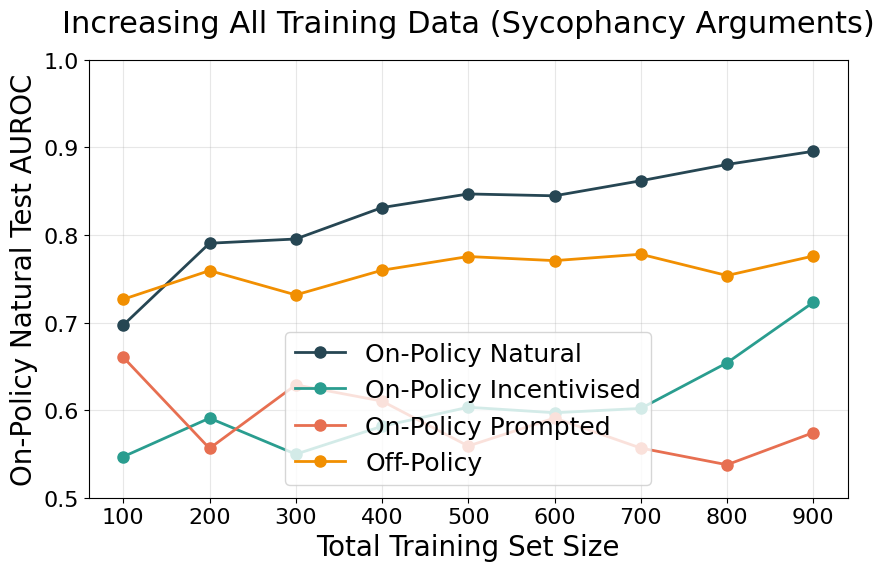

In [ ]:
# Decide if want to increase all data or just positives or just negatives
increase_data = ["all", "positives", "negatives"][0]

# Balanced data, increasing positives and negatives
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict
    
import torch
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

probe_type = ["mean", "attention_torch"][0]
behaviour = "sycophancy"
datasource = "arguments"
# datasource = "multichoice"
activations_model = "llama_3b"
response_model = "llama_3b"
# off_policy_model = "ministral_8b"
off_policy_model = "qwen_7b"
mode = "train"

# Load the best hyperparameters or set your own
dataset_name = None
cfg = ConfigDict.from_json(activations_model, probe_type, behaviour)

# Define subset sizes to test (must be even)
subset_sizes = list(range(100, 4000, 100))

# Fixed test generation method
test_generation_method = "on_policy"

# Load test dataset once (since it's fixed)
used_model_test = response_model if test_generation_method != "off_policy" else off_policy_model
activations_tensor_test, attention_mask_test, labels_tensor_test = probes.load_hf_activations_at_layer(
    behaviour, datasource, activations_model, used_model_test, test_generation_method, "test", cfg.layer, and_labels=True)
if "mean" in probe_type:
    activations_tensor_test = probes.MeanAggregation()(activations_tensor_test, attention_mask_test)
_, _, test_dataset = probes.create_activation_datasets(
    activations_tensor_test, labels_tensor_test, splits=[0, 0, 1000])

# Store results for each generation method
all_results = {}

# Iterate over different training generation methods
for generation_method in ["on_policy", "incentivised", "prompted", "off_policy"]:
    print(f"\n{'='*60}")
    print(f"Training with generation method: {generation_method}")
    print(f"{'='*60}\n")
    
    # Load training activations for this generation method
    used_model = response_model if generation_method != "off_policy" else off_policy_model
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_at_layer(
        behaviour, datasource, activations_model, used_model, generation_method, mode, cfg.layer, and_labels=True)
    if "mean" in probe_type:
        activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    
    # Split indices by class
    pos_indices = (labels_tensor == 1).nonzero(as_tuple=True)[0]
    neg_indices = (labels_tensor == 0).nonzero(as_tuple=True)[0]
    
    results = {}
    
    for n in subset_sizes:
        half = n // 2
        # Randomly sample equal numbers from each class
        if increase_data == "all":
            pos_cut = half
            neg_cut = half
        elif increase_data == "positives":
            pos_cut = half
            neg_cut = 4000
        elif increase_data == "negatives":
            pos_cut = 4000
            neg_cut = half
        pos_sample = pos_indices[torch.randperm(len(pos_indices))[:pos_cut]]
        neg_sample = neg_indices[torch.randperm(len(neg_indices))[:neg_cut]]
        subset_idx = torch.cat([pos_sample, neg_sample])
        subset_idx = subset_idx[torch.randperm(len(subset_idx))]  # shuffle order
    
        # Select activations and labels
        activ_subset = activations_tensor[subset_idx]
        label_subset = labels_tensor[subset_idx]
    
        # Create datasets (e.g., 80% train, 20% val)
        n_train = int(0.8 * len(label_subset))
        n_val = len(label_subset) - n_train
        train_dataset, val_dataset, _ = probes.create_activation_datasets(
            activ_subset, label_subset, splits=[n_train, n_val, 0]
        )
    
        # Initialise and train probe
        if probe_type == "mean":
            probe = probes.SklearnLogisticProbe(cfg)
        elif probe_type == "mean_torch":
            probe = probes.TorchLinearProbe(cfg)
        elif probe_type == "attention_torch":
            probe = probes.TorchAttentionProbe(cfg)
    
        probe.fit(train_dataset, val_dataset)
    
        # Evaluate on the fixed test set
        eval_dict, _, _ = probe.eval(test_dataset)
        results[n] = eval_dict["roc_auc"]
    
        print(f"Subset size {n} → ROC-AUC: {eval_dict['roc_auc']:.3f}")
    
    # Store results for this generation method
    all_results[generation_method] = results

# Define color mapping for each generation method
color_map = {
    "on_policy": "#264653",      # dark blue
    "incentivised": "#2A9D8F",   # teal green
    "prompted": "#E76F51",       # red/orange
    "off_policy": "#F18F01"      # yellow/orange
}

# Define display names
label_map = {
    "on_policy": "On-Policy Natural",
    "incentivised": "On-Policy Incentivised",
    "prompted": "On-Policy Prompted",
    "off_policy": "Off-Policy"
}

# Determine x-axis offset based on increase_data
if increase_data == "all":
    x_offset = 0
    x_label_suffix = ""
elif increase_data == "positives":
    x_offset = 2000  # starting with all negatives
elif increase_data == "negatives":
    x_offset = 2000  # starting with all positives

# Create title with proper formatting
increase_data_display = increase_data.capitalize().replace("Positives", "Positive").replace("Negatives", "Negative")
behaviour_display = behaviour.capitalize()
datasource_display = datasource.capitalize()
plot_title = f"Increasing {increase_data_display} Training Data ({behaviour_display} {datasource_display})"

# Set font sizes
plt.rcParams.update({'font.size': 16})

# Plot all results on the same graph
plt.figure(figsize=(9, 6))
for gen_method, results in all_results.items():
    if x_offset == 0:
        x_values = results.keys()
    else:
        x_values = [(x/2) + x_offset for x in results.keys()]
    plt.plot(x_values, list(results.values()), 
             marker='o', 
             label=label_map[gen_method],
             color=color_map[gen_method],
             linewidth=2,
             markersize=8)

plt.xlabel(f"Total Training Set Size", fontsize=20)
plt.ylabel("On-Policy Natural Test AUROC", fontsize=20)
plt.title(plot_title, fontsize=22, pad=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=18, loc='lower center')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.ylim(0.5, 1.0)
# plt.subplots_adjust(top=0.92)

# Save the plot as PDF
plt.savefig(f"{datasource}_alldata_{increase_data}.pdf", format='pdf', bbox_inches='tight')

plt.show()